In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import xgboost as xgb
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import string

# Remove this in case of errors in the code 
import warnings
warnings.filterwarnings('ignore')

In [2]:
current = os.getcwd()
path = os.path.dirname(current)

### Create Dataframe

In [3]:
def read_and_assign_datasets(base_path):
    file_names = [
        'usd_chf.csv', 'cpi.csv', 'us_rates.csv', 'nasdaq.csv', 'snp.csv', 
        'eur_usd.csv', 'gdp.csv', 'silver.csv', 'oil.csv', 'platinum.csv', 
        'palladium.csv', 'gold.csv'
    ]
    
    for file_name in file_names:
        # Create a variable name by stripping '.csv' from the file name
        dataset_name = file_name.split('.')[0]
        
        # Read the CSV file
        df = pd.read_csv(f'{base_path}/data_staging/{file_name}')
        
        # Assign the DataFrame to a variable with the name of the dataset
        globals()[dataset_name] = df

read_and_assign_datasets(path)

In [5]:
def EMA30(gold):
    gold['gold EMA_30'] = gold['gold open'].ewm(span=30).mean()
    return gold
# We will use gold's opening price's 30 day exponential moving average as a feature 
gold = EMA30(gold)

In [7]:
gold

,date,gold open,gold high,gold low,gold close,gold volume,gold EMA_30
0,2004-11-18,44.43,44.490,44.07,44.38,5992000,44.430000
1,2004-11-19,44.49,44.920,44.47,44.78,11655300,44.461000
2,2004-11-20,44.49,44.920,44.47,44.78,11655300,44.471318
3,2004-11-21,44.49,44.920,44.47,44.78,11655300,44.476466
4,2004-11-22,44.75,44.970,44.74,44.95,11996000,44.538701
...,...,...,...,...,...,...,...
7245,2024-09-19,238.24,239.515,237.39,239.17,6108226,233.480645
7246,2024-09-20,241.11,242.625,240.47,242.21,7737416,233.972861
7247,2024-09-21,241.11,242.625,240.47,242.21,7737416,234.433322
7248,2024-09-22,241.11,242.625,240.47,242.21,7737416,234.864075


### Dataframe Preparation

In [10]:
# dfs start at different dates. find which one has the most recent start date and trim the dataframes
def most_recent_start_date(*dfs):

    most_recent_date = None
    
    for df in dfs:
        if not df.empty:
            df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
            start_date = df.iloc[0]['date'] 
            if most_recent_date is None or start_date > most_recent_date:
                most_recent_date = start_date

    # Trim the dataframes based on the most recent start date
    trimmed_dfs = []
    for df in dfs:
        trimmed_df = df[df['date'] >= most_recent_date]  
        trimmed_dfs.append(trimmed_df) 

    # Merge all dataframes on the 'date' column
    if trimmed_dfs:
        merged_df = trimmed_dfs[0]
        for df in trimmed_dfs[1:]:
            merged_df = pd.merge(merged_df, df, on='date', how='inner')
    
        return merged_df
    else:
        return pd.DataFrame() 

In [14]:
model = most_recent_start_date(snp, nasdaq, us_rates, cpi, usd_chf, eur_usd, gdp, silver, oil, platinum, palladium, gold)

# Set index as date index since we are working with a time series dataframe 
model.set_index('date', inplace=True)

model = model.loc[:, ~model.columns.str.contains('high|low|close|volume', regex=True)]

# Remove weekends
model['is_weekend'] = model.index.weekday >= 5
model = model[model['is_weekend']==False]
model.drop(columns='is_weekend',inplace=True)

model = model[[col for col in model.columns if col != 'gold open'] + ['gold open']]

model.to_csv(path+'/data_model/model_dataset.csv')

In [12]:
model

,sp500 open,nasdaq open,us_rates_%,CPI,usd_chf,eur_usd,GDP,silver open,oil open,platinum open,palladium open,gold EMA_30,gold open
date,,,,,,,,,,,,,
2010-01-14,114.49,46.26,0.11,217.488,1.0206,1.4478,14764.610,18.58,39.30,160.13,43.93,110.304791,111.51
2010-01-15,114.73,46.46,0.11,217.488,1.0264,1.4376,14764.610,18.54,38.97,160.68,45.18,110.372223,111.35
2010-01-18,114.73,46.46,0.11,217.488,1.0264,1.4376,14764.610,18.54,38.97,160.68,45.18,110.549524,111.35
2010-01-19,113.62,45.96,0.11,217.488,1.0340,1.4269,14764.610,18.53,38.07,162.23,46.01,110.575361,110.95
2010-01-20,114.28,46.27,0.11,217.488,1.0453,1.4094,14764.610,18.31,38.23,163.51,46.59,110.536305,109.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-17,565.10,476.29,5.33,314.121,0.8479,1.1085,28652.337,29.33,70.90,90.04,99.50,232.804994,238.08
2024-09-18,563.74,474.70,5.33,314.121,0.8479,1.1085,28652.337,29.29,71.01,89.36,100.45,233.152413,238.19
2024-09-19,571.01,482.61,5.33,314.121,0.8479,1.1085,28652.337,29.58,72.22,90.34,99.93,233.480645,238.24


In [108]:
# XGBoost does not handle extrapolation well. We need to know if we are extrapolating

model_range = model.copy()

model_range['max_range'] = model_range['gold open'].expanding().max()
model_range['min_range'] = model_range['gold open'].expanding().min()

model_range['min_range'] = model_range['min_range'].shift(1)
model_range['max_range'] = model_range['max_range'].shift(1)

#### XGBoost implementation

In [109]:
# Feature matrix and target vector
X = model.iloc[:,:-1]
y = model.iloc[:,-1:]


# last 300 days as test set
# Create column to divide into train and test
X['split'] = 'train'
mask = X.index.isin(X.index[-300:])
X.loc[mask, 'split'] = 'test'

y['split'] = 'train'
mask = y.index.isin(y.index[-300:])
y.loc[mask, 'split'] = 'test'

X_train = X[X['split']=='train']
X_test = X[X['split']=='test']

y_train = y[y['split']=='train']
y_test = y[y['split']=='test']

X_train.drop(columns='split',inplace=True)
X_test.drop(columns='split',inplace=True)
y_test.drop(columns='split',inplace=True)
y_train.drop(columns='split',inplace=True)

In [110]:
# Scale the features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [111]:
# Grid Search to find the best parameters, without regularization

param_grid = {
    'max_depth': [1, 2, 3, 5, 7, 10],  
    'learning_rate': [0.003, 0.01, 0.03, 0.1, 0.3, 1.0],  
    'n_estimators': [100, 300, 500, 1000, 1500, 2000],  
}

In [112]:
xgb_model = XGBRegressor(objective='reg:squarederror')

splits = 11

# Initialize TimeSeriesSplit with the number of splits
tscv = TimeSeriesSplit(n_splits=splits) 

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_root_mean_squared_error', cv=tscv, verbose=1, n_jobs=-1)

In [113]:
grid_search.fit(X_train, y_train)

# Best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)

Fitting 11 folds for each of 216 candidates, totalling 2376 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}


In [114]:
reg = {
    'min_child_weight': [3, 5, 10],  
    'subsample': [0.3, 0.7, 0.9, 1.0],  
    'colsample_bytree': [0.4, 0.7, 0.9],  
    'colsample_bylevel': [0.4, 0.7, 0.9],  
    'min_child_weight': [1, 5, 10, 30, 60, 100],  
    'reg_alpha': [0.01, 0.1],  
    'reg_lambda': [0.5, 1.0],  
    'gamma': [0.1, 0.3] 
}

In [115]:
params_reg = {key: [value] for key, value in grid_search.best_params_.items()}

In [116]:
params_reg.update(reg)

In [117]:
params_reg

{'learning_rate': [0.1],
 'max_depth': [2],
 'n_estimators': [100],
 'min_child_weight': [1, 5, 10, 30, 60, 100],
 'subsample': [0.3, 0.7, 0.9, 1.0],
 'colsample_bytree': [0.4, 0.7, 0.9],
 'colsample_bylevel': [0.4, 0.7, 0.9],
 'reg_alpha': [0.01, 0.1],
 'reg_lambda': [0.5, 1.0],
 'gamma': [0.1, 0.3]}

In [118]:
# grid search, adding regularization parameters

grid_search = GridSearchCV(estimator=xgb_model, param_grid=params_reg, 
                           scoring='neg_root_mean_squared_error', cv=tscv, verbose=1, n_jobs=-1)

In [119]:
grid_search.fit(X_train, y_train)

# Best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)

Fitting 11 folds for each of 1728 candidates, totalling 19008 fits
Best parameters found:  {'colsample_bylevel': 0.9, 'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.7}


In [120]:
best_model = grid_search.best_estimator_

y_pred_test = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

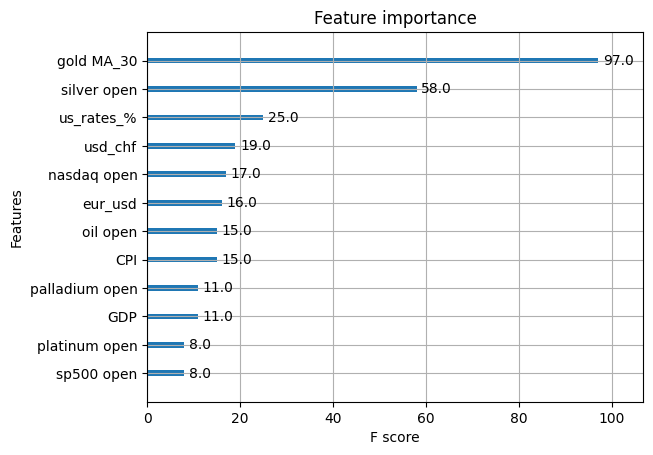

In [121]:
# To understand which features have a greater impact on gold valuation
xgb.plot_importance(best_model)

Train RMSE: 0.673, Validation RMSE: 24.123


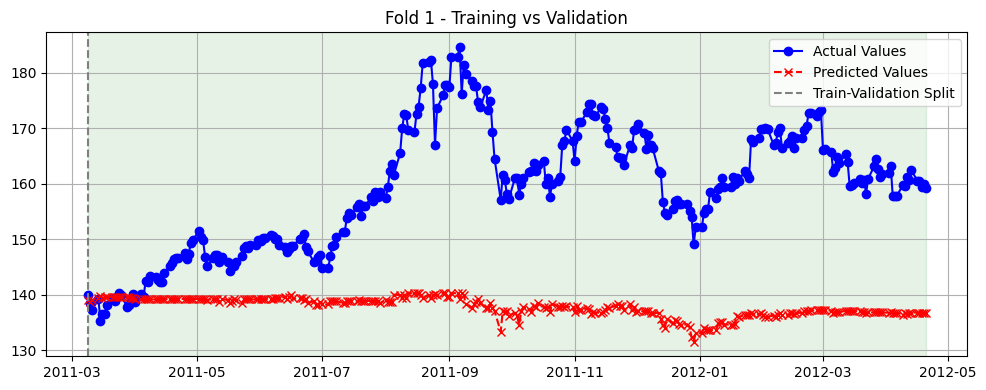

Train RMSE: 1.266, Validation RMSE: 3.899


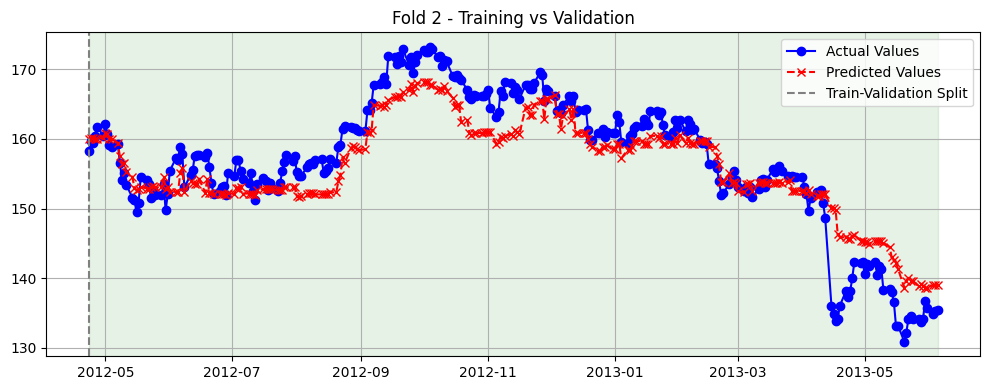

Train RMSE: 1.512, Validation RMSE: 4.928


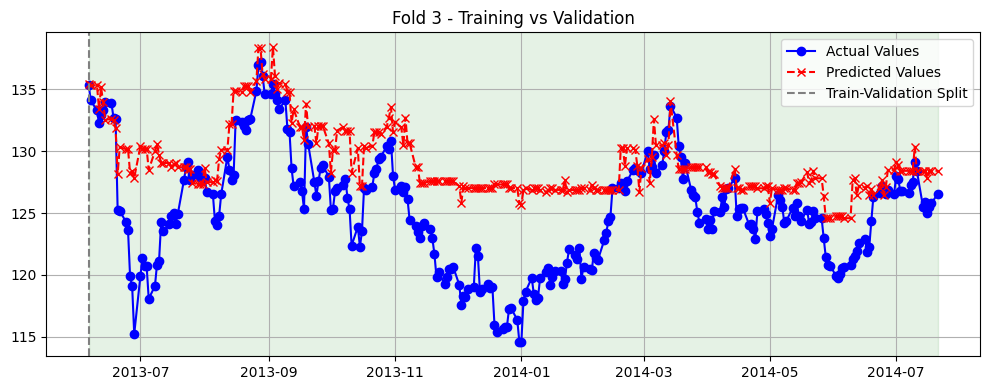

Train RMSE: 1.673, Validation RMSE: 2.649


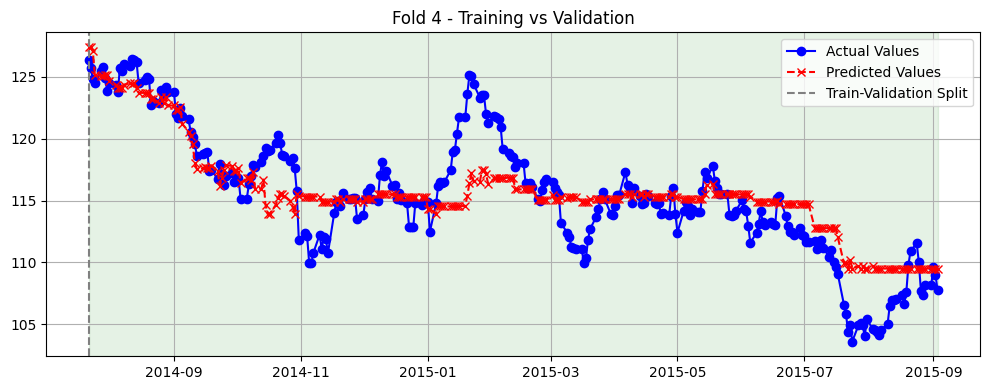

Train RMSE: 1.657, Validation RMSE: 3.754


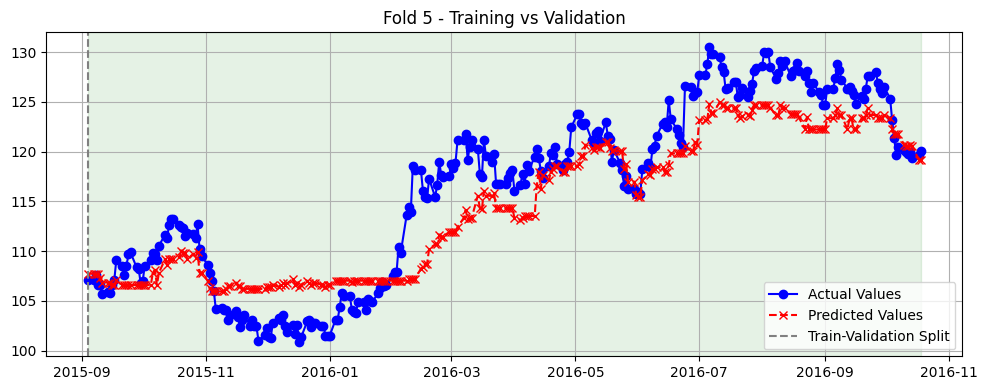

Train RMSE: 1.765, Validation RMSE: 1.987


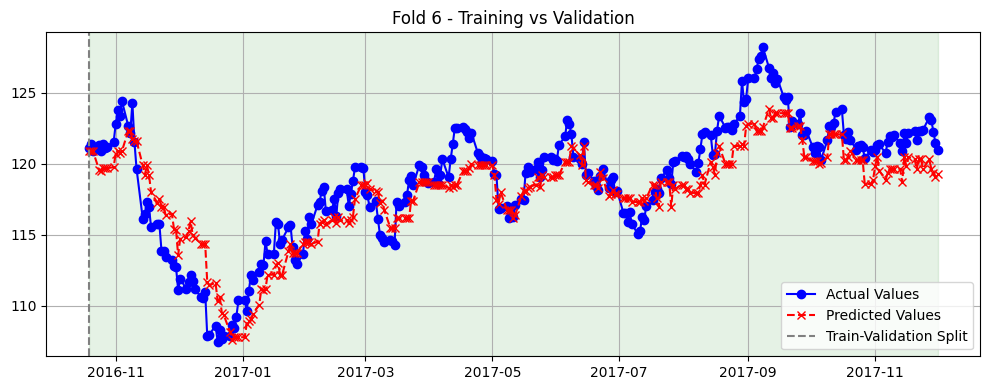

Train RMSE: 1.763, Validation RMSE: 2.967


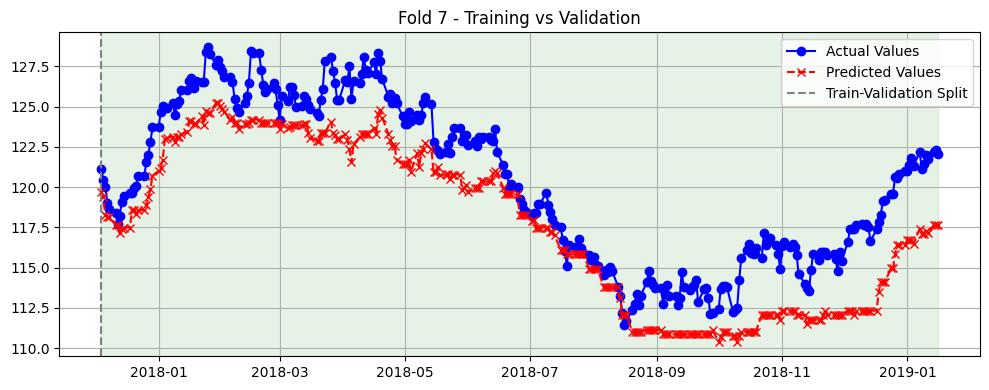

Train RMSE: 1.764, Validation RMSE: 7.452


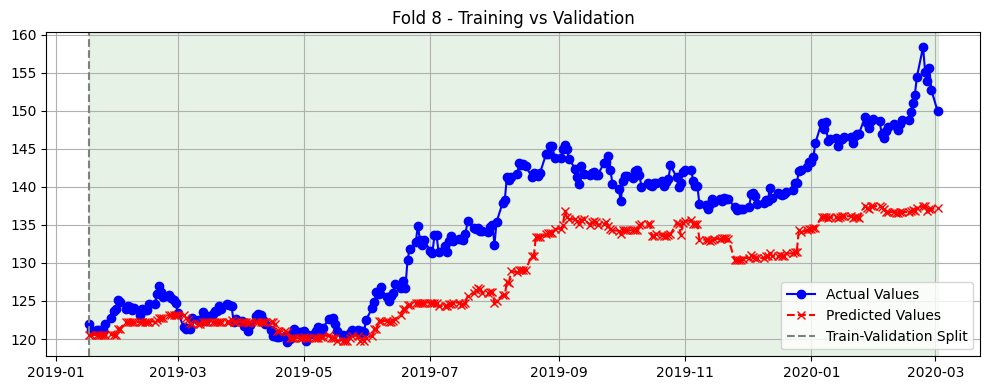

Train RMSE: 1.903, Validation RMSE: 11.5


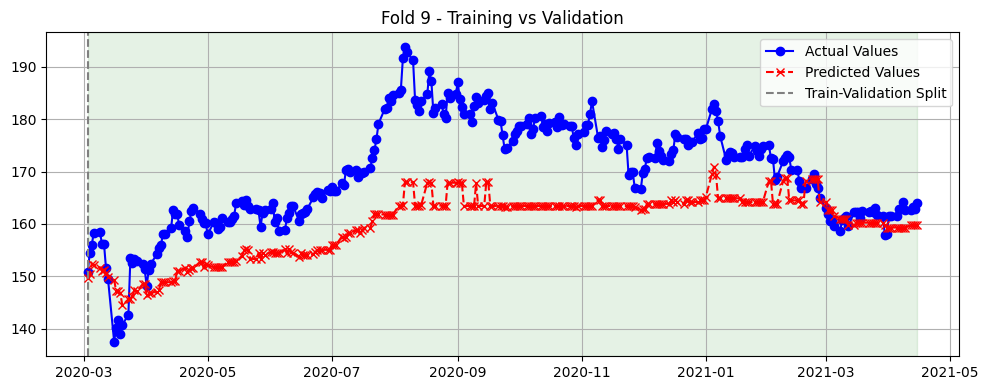

Train RMSE: 2.173, Validation RMSE: 4.997


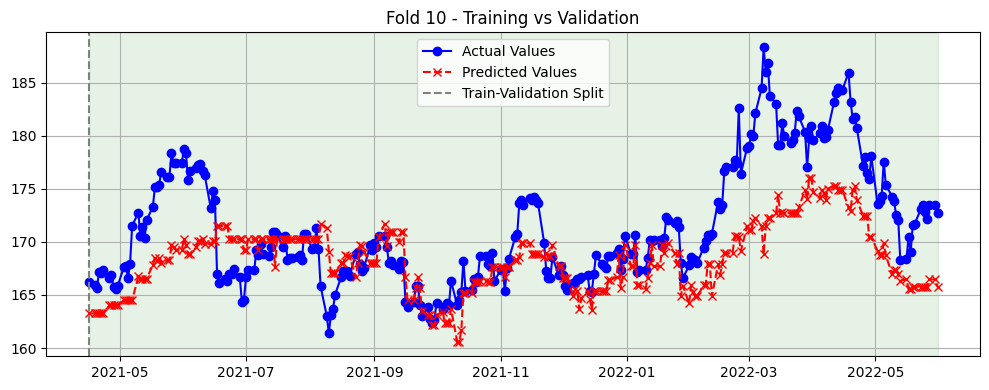

Train RMSE: 2.295, Validation RMSE: 4.198


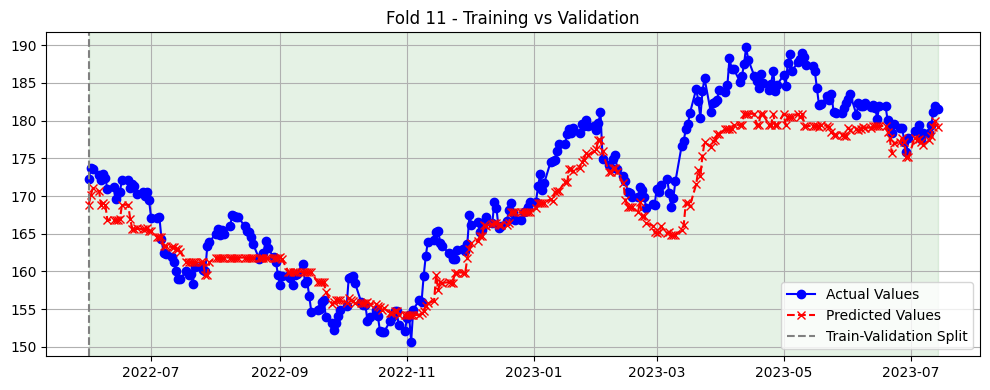

****** Average validation RMSE: 6.586783275790466 ******
Test RMSE: 23.91532054455476


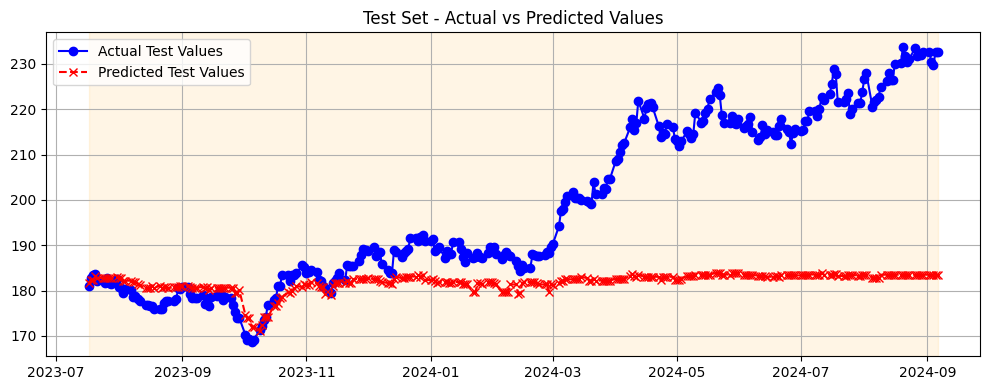

Test RMSE: 4.918396626787044


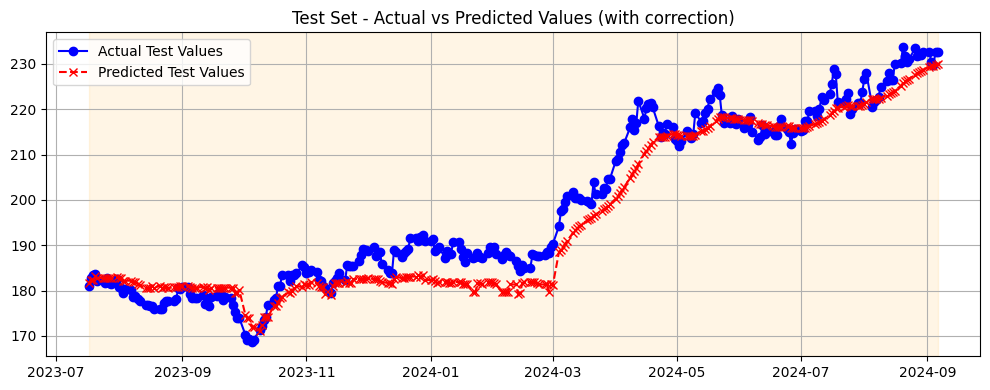

In [122]:
# Ensure y_train and y_test are NumPy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Initialize XGBRegressor model
xgboost_model = XGBRegressor()

param_grid = grid_search.best_params_
xgboost_model.set_params(**param_grid)


rmse_list = []
fold = 1

for train_index, val_index in tscv.split(X_train_scaled):

    # Split into train and validation sets
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Train the model on the training fold
    xgboost_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_val_preds = xgboost_model.predict(X_val_fold)
    
    # Predict on the training fold
    y_train_preds = xgboost_model.predict(X_train_fold)
    
    # Calculate performance metrics
    rmse_train = np.sqrt(mean_squared_error(y_train_fold, y_train_preds))
    rmse_val = np.sqrt(mean_squared_error(y_val_fold, y_val_preds))
    
    print(f'Train RMSE: {round(rmse_train, 3)}, Validation RMSE: {round(rmse_val, 3)}')
    rmse_list.append(rmse_val)
    
    # Plot predictions vs actual values for each fold
    train_dates = X_train.index[train_index]
    val_dates = X_train.index[val_index]

    # Create the figure
    fig = plt.figure(figsize=(10, 4))
    
    # Plot validation data predictions
    plt.plot(val_dates, y_val_fold, color='blue', marker='o', label='Actual Values')
    plt.plot(val_dates, y_val_preds, color='red', linestyle='--', marker='x',  label='Predicted Values')
    
    # Highlight the train-validation split
    separation_date = X_train.index[val_index[0]]
    plt.axvline(x=separation_date, color='gray', linestyle='--', label='Train-Validation Split')

    # Shade the validation area
    plt.axvspan(val_dates[0], val_dates[-1], color='green', alpha=0.1)
    
    plt.title(f'Fold {fold} - Training vs Validation')
    plt.legend()
    plt.grid(True)

    # Adjust layout to make sure everything fits
    plt.tight_layout()
    plt.show()
    
    fold += 1

# Summary of validation performance
print(f'****** Average validation RMSE: {np.mean(rmse_list)} ******')

# Now train on the full training set and evaluate on the test set
xgboost_model.fit(X_train_scaled, y_train)
y_test_preds = xgboost_model.predict(X_test_scaled)

# Test performance
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))

print(f'Test RMSE: {test_rmse}')

fig = plt.figure(figsize=(10, 4))

plt.plot(X_test.index, y_test, label='Actual Test Values', color='blue', marker='o')
plt.plot(X_test.index, y_test_preds, label='Predicted Test Values', color='red', linestyle='--', marker='x')
plt.axvspan(X_test.index[0], X_test.index[-1], color='orange', alpha=0.1) # shade
plt.title('Test Set - Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

test_df = X_test.copy()
test_df['gold open'] = y_test
test_df['gold open pred'] = y_test_preds

# get first test row
first_test_row = test_df.index[0] 

# check what were the limits before the test set to avoid bad results in case of extrapolation
model_range_limits = model_range[model_range.index == first_test_row]

lower_limit = model_range_limits['min_range'][0]
higher_limit = model_range_limits['max_range'][0]

test_df['min_range'] = lower_limit
test_df['max_range'] = higher_limit
test_df['outside_range'] = test_df.apply( lambda x: False if x['gold open']>x['min_range'] and x['gold open']<x['max_range'] else True, axis = 1)
test_df['gold open pred'] = test_df.apply(lambda x: x['gold EMA_30'] if x['outside_range']==True else x['gold open pred'], axis = 1)

# Test performance
test2_rmse = np.sqrt(mean_squared_error(test_df[['gold open']], test_df['gold open pred']))

print(f'Test RMSE: {test2_rmse}')

fig = plt.figure(figsize=(10, 4))

plt.plot(test_df.index, test_df['gold open'], label='Actual Test Values', color='blue', marker='o')
plt.plot(test_df.index, test_df['gold open pred'], label='Predicted Test Values', color='red', linestyle='--', marker='x')
plt.axvspan(X_test.index[0], X_test.index[-1], color='orange', alpha=0.1) # shade
plt.title('Test Set - Actual vs Predicted Values (with correction)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [123]:
test_df.drop(columns={'min_range', 'max_range', 'outside_range'}, inplace=True)

# add error to the test dataframe
test_df['Error'] = test_df['gold open'] - test_df['gold open pred']

test_df.to_csv(path+'/data_model/model_results.csv',index = False)

Future Work: Instead of using Gold MA 30 when the test set needs extrapolation, build a different ML algorithm for this case, resulting in a hybrid machine learning model.